# Using the sampler

`hlm_gibbs` is a generic gibbs sampling framework for spatially-correlated variance components models. The current supported models are:

- `hlm.both` contains specifications with correlated errors in both levels, with the first statement `se/sma` describing the lower level and the second statement `se/sma` describing the upper level. In addition, `MVCM`, the multilevel variance components model with no spatial correlation, is in the `both` namespace. 
- `hlm.lower` contains two specifications, `se/sma`, that can be used for a variance components model with correlated lower-level errors.
- `hlm.upper` contains two specifications, `se/sma` that can be used for a variance components model with correlated upper-level errors. 

Depending on the structure of the model, you need at least:
- `X`, data at the lower level
- `Y`, system response in the lower level
- `membership` or `Delta`, the membership vector relating each observation to its group or the "dummy variable" matrix encoding the same information. 

Then, if spatial correlation is desired, `M` is the "upper-level" weights matrix and `W` the lower-level weights matrix. 

Finally, there are many configuration and tuning options that can be passed in at the start, or assigned after the model is initialized. 

First, though, let's set up some data for a model on southern counties relating `DNL90` to `GI89`, `BLK90`, and `HR90`, with statewide average `FH90` as an upper-level predictor. 

In [1]:
#seaborn is required for the traceplots
import pysal as ps
import hlm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

First, we'll will read in the data and assign to the correct response, upper-, and lower-level data. 

In [2]:
data = ps.pdio.read_files(ps.examples.get_path('south.shp'))
data = data[data.STATE_NAME != 'District of Columbia']
X = data[['GI89', 'BLK90', 'HR90']].values
N = X.shape[0]
Z = data.groupby('STATE_NAME')['FH90'].mean()
Z = Z.values.reshape(-1,1)
J = Z.shape[0]

Y = data.DNL90.values.reshape(-1,1)

Then, we'll construct some weights from the files. 

In [3]:
W2 = ps.queen_from_shapefile(ps.examples.get_path('us48.shp'), 
                             idVariable='STATE_NAME')
W2 = ps.w_subset(W2, ids=data.STATE_NAME.unique().tolist()) #only keep what's in the data
W1 = ps.queen_from_shapefile(ps.examples.get_path('south.shp'),
                             idVariable='FIPS')
W1 = ps.w_subset(W1, ids=data.FIPS.tolist()) #again, only keep what's in the data

W1.transform = 'r'
W2.transform = 'r'

With the data, upper-level weights, and lower-level weights, we can construct a membership vector *or* a dummy data matrix. For now, I'll create the membership vector.

In [4]:
membership = data.STATE_NAME.apply(lambda x: W2.id_order.index(x)).values

But, we could also build the dummy variable matrix using `pandas`, if we have a suitable categorical variable:

In [5]:
Delta_frame = pd.get_dummies(data.STATE_NAME)
Delta = Delta_frame.values

Every call to the sampler is of the following form:

`sampler(Y, X, W, M, Z, membership, Delta, n_samples, **configuration)`

Where `W`, `M` are passed if appropriate, `Z` is passed if used, and only one of `membership` or `Delta` is required. In the end, `Z` is appended to `X`, so the effects pertaining to the upper level will be at the tail end of the $\beta$ effects vector. If both `Delta` and `membership` are supplied, they're verified against each other to ensure that they agree before they are used in the model. 

Every sampler uses, either in whole or in part, `hlm.both.generic`, which implements the full generic sampler discussed in the working paper. For efficiency, the upper-level samplers modify this runtime to avoid processing the full lower-level covariance matrix. 

Thus, with the data and a membership vector, a model can be fit by calling:

In [6]:
vcsma = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                      n_samples=5000, tuning=500)

/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


The results and state of the sampler are stored within the `vcsma` object. I'll step through the most important parts of this object. 

# `trace`

The quickest way to get information out of the model is via the trace object. This is where the results of the tracked parameters are stored each iteration. Any variable in the sampler state can be added to the tracked params. Trace objects are essentially dictionaries with the keys being the name of the tracked parameter and the values being a list of each iteration's sampler output.

In [7]:
vcsma.trace.varnames

['Betas', 'Sigma2', 'Tau2', 'Lambda', 'Alphas']

In this case, `Lambda` is the upper-level moving average parameter, `Alphas` is the vector of correlated group-level random effects, `Tau2` is the upper-level variance, `Betas` are the marginal effects, and `Sigma2` is the lower-level error variance.

I'm working to rename these to be consistent with the draft naming convention, but am writing unittests first to make sure that the rename doesn't induce errors. 

I've written two helper functions for working with traces. First is to just dump all the output into a pandas dataframe, which makes it super easy to do work on the samples, or write them out to `csv` and assess convergence in R's `coda` package.

In [8]:
trace_dataframe = vcsma.trace.to_df()

In [9]:
trace_dataframe.mean()

Lambda        0.766717
Sigma2        1.277206
Tau2          0.232024
Alphas_0      0.308541
Alphas_1      0.742316
Alphas_2      0.731663
Alphas_3      0.433992
Alphas_4      0.379480
Alphas_5     -0.866960
Alphas_6      0.148806
Alphas_7      0.098672
Alphas_8     -0.754410
Alphas_9     -0.558129
Alphas_10    -0.133320
Alphas_11     0.003053
Alphas_12    -0.325798
Alphas_13    -0.337959
Alphas_14     0.130551
Alphas_15     0.098818
Betas_0       9.093728
Betas_1     -11.844991
Betas_2       0.003461
Betas_3       0.030215
Betas_4      -0.043534
dtype: float64

The second is a method to plot the traces:

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


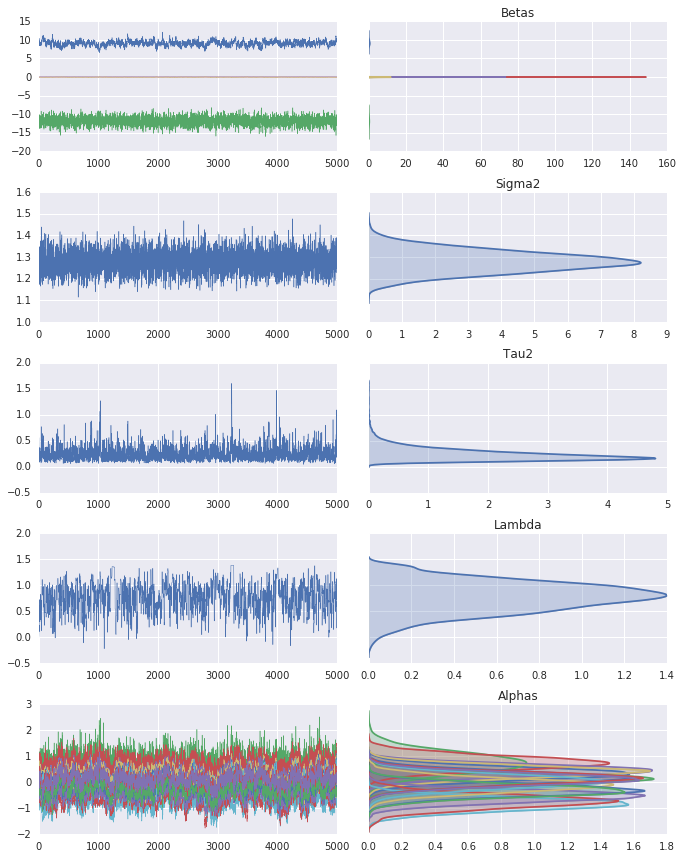

In [10]:
fig, ax = vcsma.trace.plot()
plt.tight_layout()
plt.show()

The trace object is a subclass of the standard python dictionary that allows for its elements to be accessed by dot notation, `.get`, or by the typical name-specific slicing: 

In [11]:
vcsma.trace.Lambda[-1] #is equivalent to the following:
#vcsma.trace['Lambda'][-1]
#vcsma.trace.get('Lambda')[-1]

0.69088744240431255

In the future, it may make sense to modify the slicing behavior to allow for iteration-specific subsetting, so that `trace[100:]` would give the trace with the first 100 elements removed. 

In addition, data in the trace is stored in lists. The sampler appends new values to this list each iteration. 

If you're working with the data substantially, just use `trace.to_df`, since pandas dataframes are much easier to work with. 

To get stuff like posterior quantiles, you can use the attendant pandas dataframe functionality, like `describe`. 

In [12]:
df = vcsma.trace.to_df()

In [13]:
df.describe()

,Lambda,Sigma2,Tau2,Alphas_0,Alphas_1,Alphas_2,Alphas_3,Alphas_4,Alphas_5,Alphas_6,...,Alphas_11,Alphas_12,Alphas_13,Alphas_14,Alphas_15,Betas_0,Betas_1,Betas_2,Betas_3,Betas_4
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.766717,1.277206,0.232024,0.308541,0.742316,0.731663,0.433992,0.379480,-0.866960,0.148806,...,0.003053,-0.325798,-0.337959,0.130551,0.098818,9.093728,-11.844991,0.003461,0.030215,-0.043534
std,0.283057,0.049026,0.127130,0.251061,0.412403,0.273122,0.226161,0.242647,0.246681,0.259058,...,0.277827,0.238633,0.250540,0.243599,0.243712,0.691172,1.124104,0.002612,0.005278,0.035175
min,-0.222647,1.114109,0.041333,-0.593088,-0.880090,-0.537455,-0.316243,-0.437794,-1.756178,-0.752014,...,-0.973372,-1.120906,-1.250463,-0.656771,-0.842041,6.635997,-16.048654,-0.006154,0.010171,-0.169464
25%,0.576475,1.243308,0.147964,0.143531,0.464534,0.548285,0.285678,0.220639,-1.028922,-0.018897,...,-0.182646,-0.482853,-0.502870,-0.029217,-0.061944,8.640080,-12.589831,0.001684,0.026780,-0.064759
50%,0.782937,1.276352,0.201060,0.310582,0.731781,0.731244,0.437807,0.387947,-0.861425,0.153212,...,0.006931,-0.325915,-0.339225,0.136570,0.099924,9.098844,-11.855798,0.003459,0.030152,-0.042214
75%,0.967878,1.309424,0.282579,0.477174,1.016415,0.916221,0.590868,0.543126,-0.697662,0.322672,...,0.188394,-0.160284,-0.167577,0.297502,0.259934,9.547547,-11.061595,0.005230,0.033846,-0.020200
max,1.382690,1.476384,1.601098,1.192098,2.503563,1.694635,1.153007,1.209314,-0.005890,1.096372,...,0.937809,0.492381,0.561262,0.919789,1.059585,12.124211,-8.216864,0.013521,0.049684,0.079243


### Formal trace statistics:

To compute trace diagnostics, you can use existing python packages. I plan on implementing at least the Gelman-Rubin potential scale reduction factor (PSRF) statistic (an ANOVA-based measure of ergodicity and convergence of multiple chains) and the geweke statistic, and writing or wrapping existing implementations of the PSRF, geweke, and autocorrelation plots and diagnostics. 

Unfortunately, `pymc3`'s diagnostic functions don't work with arbitrary arrays of values. And, you can't really "initialize" one of their traces and stuff it full of what you want. 

Currently, aside from just computing the statistics on the pandas dataframe form of the trace, you can also use stuff like `statsmodels` to compute the chain autocorrelation:

In [14]:
from statsmodels.api import tsa
#if you don't have it, try removing the comment and:
#! pip install pymc3

For example, the partial autocorrelation in the lambda chain over the past 40 lags in the $\lambda$ sample is:

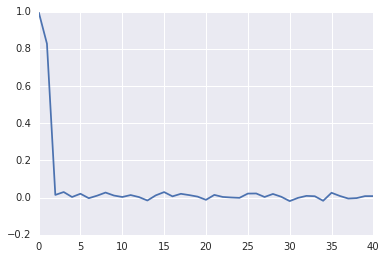

In [15]:
plt.plot(tsa.pacf(df.Lambda))

So, the chain is close-to-first order:

In [16]:
tsa.pacf(df.Lambda)[0:3]

array([ 1.        ,  0.82743508,  0.0144225 ])

We could do this for many parameters, too. An Autocorrelation/Partial Autocorrelation plot can be made of the marginal effects by:

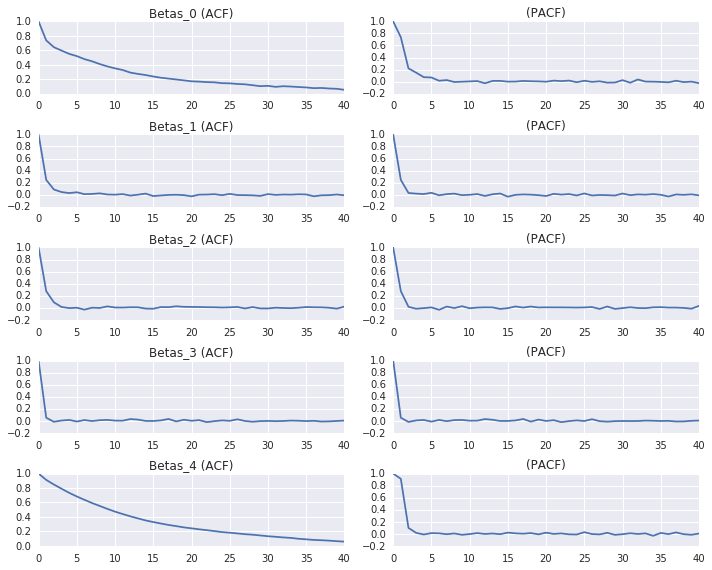

In [17]:
betas = [c for c in df.columns if c.startswith('Beta')]
f,ax = plt.subplots(len(betas), 2, figsize=(10,8))
for i, col in enumerate(betas):
    ax[i,0].plot(tsa.acf(df[col].values))
    ax[i,1].plot(tsa.pacf(df[col].values)) #the pacf plots take a while
    ax[i,0].set_title(col +' (ACF)')
    ax[i,1].set_title('(PACF)')
f.tight_layout()
plt.show()

This is something again that I'm going to wrap up into a diagnostic plot.  

Most of the practitioners I've seen in python output their model results to `R` to use the `coda` Bayesian Diagnostics package.

These diagnostics are important checks on validity, and serve to formalize the logic of trace plot inspection.

The most helpful ones (in my opinion) are the Gelman-Rubin diagnostic and the Geweke diagnostic. The Gelman-Rubin statistic, also known as the "potential scale reduction factor," is an ANOVA test between multiple chains that measures how likely it is that the distributions drawn from the trace are the same. So, let's run another chain:

#### write the dataframe out to a csv and load it in R as an mcmc object:

In [18]:
df.to_csv('model_run.csv', index=False)

In [19]:
%load_ext rpy2.ipython

In [20]:
%%R
#install_package(coda) # if you don't have coda installed in R
library(coda)
trace <- read.csv('model_run.csv')
trace <- coda::mcmc(trace, start=500)

coda::geweke.diag(trace)


Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

   Lambda    Sigma2      Tau2  Alphas_0  Alphas_1  Alphas_2  Alphas_3  Alphas_4 
-1.903931 -1.952078 -0.552043 -0.415133 -1.108863 -0.363955 -0.196839 -0.425794 
 Alphas_5  Alphas_6  Alphas_7  Alphas_8  Alphas_9 Alphas_10 Alphas_11 Alphas_12 
-0.142884 -0.411852 -0.001707 -0.611931 -0.202954  0.078213 -0.222248 -0.044373 
Alphas_13 Alphas_14 Alphas_15   Betas_0   Betas_1   Betas_2   Betas_3   Betas_4 
 0.057303  0.121722 -0.227471 -0.109759 -0.312055 -2.204327  0.398186  0.316436 



#### Use the `%Rpush` command if you're conducting the analysis from within the notebook:

In [21]:
trace2 = df

In [22]:
%Rpush trace2

In [23]:
%%R 
trace2 <- coda::mcmc(trace2, start=500)
coda::geweke.diag(trace2)


Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

   Lambda    Sigma2      Tau2  Alphas_0  Alphas_1  Alphas_2  Alphas_3  Alphas_4 
-1.903931 -1.952078 -0.552043 -0.415133 -1.108863 -0.363955 -0.196839 -0.425794 
 Alphas_5  Alphas_6  Alphas_7  Alphas_8  Alphas_9 Alphas_10 Alphas_11 Alphas_12 
-0.142884 -0.411852 -0.001707 -0.611931 -0.202954  0.078213 -0.222248 -0.044373 
Alphas_13 Alphas_14 Alphas_15   Betas_0   Betas_1   Betas_2   Betas_3   Betas_4 
 0.057303  0.121722 -0.227471 -0.109759 -0.312055 -2.204327  0.398186  0.316436 



#### to do the Gelman-Rubin statistic, we need to run another chain. 

So, we'll run another chain just by re-doing the previous one. There're a few ways to reset a chain, duplicate its state, copy it, or etc.

But the simplest is to just rerun the same initial call. 

In [24]:
tmp = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                      n_samples=5000, tuning=500)
df2 = tmp.trace.to_df()

/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


I'm going to remove the random effects from this plot so we don't have a huge diagnostic plot:

In [25]:
df_noalpha = df.drop([col for col in df.columns if col.startswith('Alphas')], axis=1, inplace=False)
df2_noalpha = df2.drop([col for col in df2.columns if col.startswith('Alphas')], axis=1, inplace=False)

In [26]:
%Rpush df_noalpha df2_noalpha

If the partial scale reduction factor is close to 1, it means the chains are quite similar, and they've likely converged to the same posterior. If it's much larger than 1, it indicates that the between-chain variance is much larger than the within-chain variance, and it's likely that the chains are reflecting different distributions and the MCMC routine hasn't converged to the same steady state twice. 

In this case, all of our scale reduction factors are close to 1:

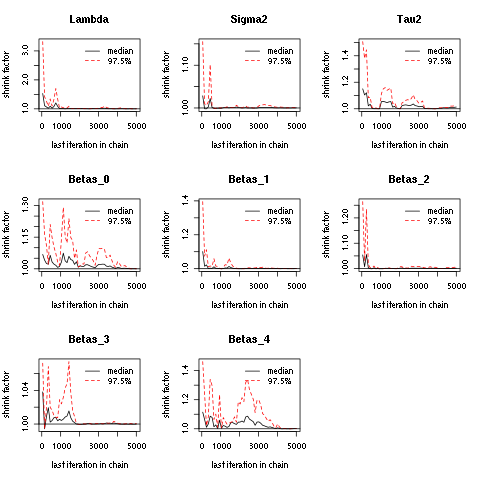

In [27]:
%%R 
multitrace <- coda::mcmc.list(list(a=coda::mcmc(df_noalpha), b=coda::mcmc(df2_noalpha)))
coda::gelman.plot(multitrace)

In [28]:
%%R
coda::gelman.diag(multitrace)

Potential scale reduction factors:

        Point est. Upper C.I.
Lambda        1.00       1.00
Sigma2        1.00       1.00
Tau2          1.01       1.03
Betas_0       1.00       1.00
Betas_1       1.00       1.00
Betas_2       1.00       1.01
Betas_3       1.00       1.00
Betas_4       1.00       1.00

Multivariate psrf

1.01


# `draw` and `sample`

These two functions are used to call the underlying Gibbs sampler. They take no arguments, and operate on the sampler in place. `draw` provides a single new sample:

In [29]:
vcsma.draw()

And sample steps forward an arbitrary number of times:

In [30]:
vcsma.sample(10)

At this point, we did 5000 initial samples and 11 extra samples. Thus:

In [31]:
vcsma.cycles

5011

# `state`

This is the collection of current values in the sampler. To be efficient, Gibbs sampling must keep around some of the computations used in the simulation, since sometimes the same terms show up in different conditional posteriors. So, the current values of the sampler are stored in `state`.

All of the following are tracked in the state:

In [32]:
print(vcsma.state.varnames)

['Rho_min', 'Tau2_b0', 'Betas_covm', 'Betas_cov0', 'XBetas', 'Betas_mean0', 'DeltaAlphas', 'y', 'PsiTau2', 'LogRho0', 'Sigma2_b0', 'Sigma2_an', 'In', 'PsiRhoi', 'PsiRho', 'Psi_2', 'PsiLambdai', 'Lambda', 'Rho', 'Tau2', 'PsiSigma2', 'XtX', 'Sigma2', 'Betas_cov0i', 'M', 'Sigma2_a0', 'PsiLambda', 'Lambda_min', 'Tau2_an', 'Lambda_max', 'Ij', 'PsiSigma2i', 'W', 'J', 'Rho_max', 'p', 'N', 'Psi_1', 'Alphas', 'Tau2_a0', 'X', 'PsiTau2i', 'DeltatDelta', 'Betas', 'Delta', 'LogLambda0']


You can construct traces of "extra" parameters in `state` by passing their names to the `extra_traced_params` option of the model initialization, or by adding them to the trace & traced_params manually. 

In [33]:
example = hlm.upper.SMA(Y, X, M=W2, Z=Z, membership=membership, 
                      n_samples=0, extra_traced_params=['DeltaAlphas'])

/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


In [34]:
example.traced_params

['Alphas', 'Betas', 'Sigma2', 'Tau2', 'Lambda', 'DeltaAlphas']

In [35]:
example.sample(5)

In [36]:
example.trace.DeltaAlphas

[array([[ 0.39952387],
        [ 0.39952387],
        [ 0.39952387],
        ..., 
        [ 1.00837255],
        [ 1.00837255],
        [ 1.00837255]]), array([[ 0.59357408],
        [ 0.59357408],
        [ 0.59357408],
        ..., 
        [ 0.44552682],
        [ 0.44552682],
        [ 0.44552682]]), array([[ 0.46438779],
        [ 0.46438779],
        [ 0.46438779],
        ..., 
        [ 0.25678336],
        [ 0.25678336],
        [ 0.25678336]]), array([[ 0.27606112],
        [ 0.27606112],
        [ 0.27606112],
        ..., 
        [ 0.39098594],
        [ 0.39098594],
        [ 0.39098594]]), array([[ 0.188163 ],
        [ 0.188163 ],
        [ 0.188163 ],
        ..., 
        [ 0.4715184],
        [ 0.4715184],
        [ 0.4715184]])]

# `configs`
this is where configuration options for the metropolis steps for the spatial parameter are stored. Each metropolis step has its own entry in `configs`, which stores a few recognized options. You can access these options directly through the initial call.

In [37]:
vcsma.configs

{Lambda:{ar:0.4491017964071856, proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7f8675b20cf8>, rejected:2836, adapt_step:1.01, ar_hi:0.6, accepted:2175, adapt:False, jump:0.4571699121199565, max_adapt:500, ar_low:0.4}, Rho:{proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7f8675b20cf8>, rejected:0, adapt_step:1.01, ar_hi:0.6, accepted:0, adapt:True, jump:0.5, max_adapt:500, ar_low:0.4}}

Thus, we can se the previous run's acceptance rate:

In [38]:
vcsma.configs.Lambda.ar

0.4491017964071856

If you're doing heavy customization, it makes the most sense to first initialize the class without sampling. We did this before when showing how the "extra_traced_params" option worked. 

To show, let's initialize a double-level SAR-Error variance components model, but not actually draw anything.

To do this, you pass the option `n_samples=0`.

In [39]:
vcsese = hlm.both.SESE(Y, X, W=W1, M=W2, Z=Z, membership=membership, 
                      n_samples=0, tuning=500, rho_jump=.22)

/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


This sets up the sampler with a default uninformative configuration. This means the prior precisions are all `I * .001*`, prior means are all 0, spatial parameters are set to `-1/(n-1)`, and prior scale factors are set arbitrarily. 

Options are set by assgning to the relevant property in `model.configs`. 

The model configuration object is another dictionary with a few special methods. 

Configuration options are stored for each parameter separately:

In [40]:
vcsese.configs.varnames

['Lambda', 'Rho']

In [41]:
vcsese.configs

{Lambda:{proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7f8675b20cf8>, rejected:0, adapt_step:1.01, ar_hi:0.6, accepted:0, adapt:True, jump:0.5, max_adapt:500, ar_low:0.4}, Rho:{proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7f8675b20cf8>, rejected:0, adapt_step:1.01, ar_hi:0.6, accepted:0, adapt:True, jump:0.22, max_adapt:500, ar_low:0.4}}

So, for example, if we wanted to turn off adaptation in the upper-level parameter, and fix the Metrpolis jump variance to `.25`:

In [42]:
vcsese.configs.Lambda.adapt = False
vcsese.configs.Lambda.jump  = .25

In [43]:
vcsese.configs

{Lambda:{proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7f8675b20cf8>, rejected:0, adapt_step:1.01, ar_hi:0.6, accepted:0, adapt:False, jump:0.25, max_adapt:500, ar_low:0.4}, Rho:{proposal:<scipy.stats._continuous_distns.norm_gen object at 0x7f8675b20cf8>, rejected:0, adapt_step:1.01, ar_hi:0.6, accepted:0, adapt:True, jump:0.22, max_adapt:500, ar_low:0.4}}

Another example might be to fix the prior mean of $\beta$ to the OLS estimates. One way this could be done would be to pull the `Delta` matrix out from the state, and estimate:
$$ Y = X\beta + \Delta Z + \epsilon $$
using `PySAL`: 

In [44]:
Delta = vcsese.state.Delta
DeltaZ = Delta.dot(Z)
vcsese.state.Betas_mean0 = ps.spreg.OLS(Y, np.hstack((X, DeltaZ))).betas

If you wanted to start the sampler at a given starting value, you can do so by assigning that value to the `Lambda` value in `state`. 

In [45]:
vcsese.state.Lambda = -.25

Changing the spatial parameter priors is also done by changing their prior in state. This prior must be a function that takes a value of the parameter and return the log of the prior probability for that value. 

For example, we could assign `P(\lambda) = Beta(2,1)` and zero if outside $(0,1)$, and asign $\rho$ a truncated $\mathcal{N}(0,.5)$ prior by first defining their functional form:

In [46]:
from scipy import stats

In [47]:
def Lambda_prior(val):
    if (val < 0) or (val > 1):
        return 0
    return np.log(stats.beta.pdf(val, 2,1))

In [48]:
def Rho_prior(val):
    if (val > .5) or (val < -.5):
        return 0
    return np.log(stats.truncnorm.pdf(val, -.5, .5, loc=0, scale=.5))

And then assigning to their symbols, `LogLambda0` and `LogRho0` in the state:

In [49]:
vcsese.state.LogLambda0 = Lambda_prior
vcsese.state.LogRho0 = Rho_prior

### Performance

The efficiency of the sampler is contingent on the lower-level size. If we were to estimate the draw in a dual-level SAR-Error Variance Components iteration:

In [50]:
%timeit vcsese.draw()

1 loop, best of 3: 2.7 s per loop


It takes about 2 seconds per draw on my Chromebook.

To make it easy to work with the model, you can interrupt and resume sampling at any time:

In [51]:
%time vcsese.sample(100)

CPU times: user 13min 44s, sys: 22.2 s, total: 14min 7s
Wall time: 5min 21s


In [52]:
vcsese.sample(10)

### Backends

Sometimes, the sample trace is too big to keep in memory at once. So, I wrote tools to keep the trace out of core in a sqlite database.

In [53]:
from hlm.sqlite import start_sql, trace_from_sql

By default, the sampler will not allow you to overwrite the existing model trace on file. 

In [56]:
#!rm model_trace.db

In [57]:
vcse = hlm.upper.SE(Y, X, M=W2, membership=membership, n_samples=0, tuning=500)
vcse.database = 'model_trace.db'

/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/projects/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


Then, if this option is set, the sample function automatically saves to disk every cycle, to prevent excessive memory pressure. If configuration options can be added to save every `k` iterations as well. 

In [58]:
vcse.sample(1000)

Since the trace is being kept on disk and not in the model, the trace in memory consists of a single point:

In [59]:
vcse.trace

{Betas:[array([[  7.96862039e+00],
       [ -1.07834976e+01],
       [ -3.52450551e-03],
       [  3.48360192e-02]])], Sigma2:[1.2118589894190246], Tau2:[0.083838030927293777], Lambda:[0.76155195908649287], Alphas:[array([[ 0.37656096],
       [ 1.04561945],
       [ 1.12482033],
       [ 0.61758172],
       [ 0.38954034],
       [-0.64827243],
       [ 0.2696091 ],
       [ 0.20314601],
       [-0.89072907],
       [-0.3924088 ],
       [ 0.43979513],
       [-0.09320049],
       [-0.2246557 ],
       [ 0.0248566 ],
       [ 0.08191254],
       [ 0.20912466]])]}

To get the full set of values, you can either read it in explicitly or work with it like it's a database using python's `sqlite3` library.

In [60]:
trace = trace_from_sql(vcse.database)

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


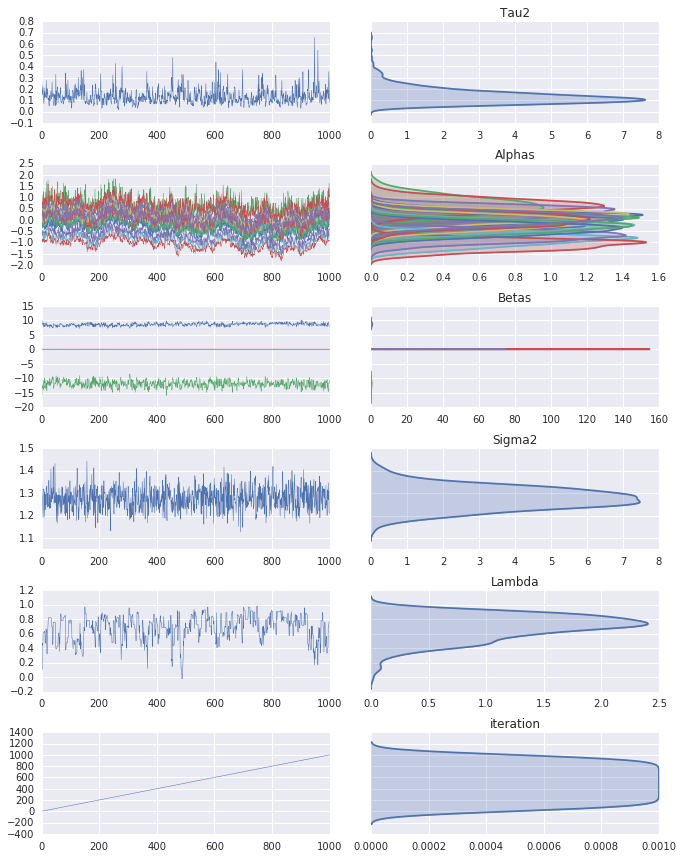

In [61]:
trace.plot()
plt.show()

# Under the Hood

### Non-Model tools

Most of the tools in the package are stored in relevant python files in the top level or a dedicated subfolder. Explaining a few:

- `abstracts.py` - the abstract class machinery to iterate over a sampling loop. This is where the "mechanics" of the sampler is defined. 
- `trace.py` - the file containing tools and methods for the `Trace` class definition. 
- `sqlite.py` - the file containing model serialization tools and the out-of-core trace storage tools. 
- `plotting/` - a folder containing tools for visualizing model output.
- `steps.py` - a file containing step methods, like `metropolis`, `slice`, or `inversion`, used for the non-analytical posteriors. 
-  `verify.py` - a file containing the checks on user input that are run for the User classes. 

### The implementation of a Model

The package is implemented so that every "model type" first sends off to the `hlm.both.Base_Generic`, which sets up the state, trace, and priors. 

Models are added by writing a `model.py` file and possibly a `sample.py` file. The `model.py` file defines a `Base/User` class pair (like `spreg`) that sets up the state and trace. It must define hyperparameters, and can precompute objects used in the sampling loop. 

The sampling loop itself is defined in `sample.py`. It must be a function that takes the model and updates it in place with a new draw from the joint posterior. This file can also split out each parameter's sample step into their own functions, which would allow users to configure alternative step methods on the fly.

Any extra functions used in the setup or estimation is stored in their `util.py` file. 

So, if I write a new model, like a varying-intercept model with endogenously-lagged intercepts, I would write:
- `sample.py`, describing a single sampling loop:

```python
def sample(VISAR):
    st = VISAR.state
    diff = st.Ay - st.XBetas - st.Delta.dot(st.Alphas)
...
```
- `model.py`, describing the subclass to setup the model, maybe looking like:

```python

class Base_VISAR(hlm.abstracts.Sampler_Mixin):
    def __init__(self, Y, X, M, membership=None, Delta=None):
    ...
```
Somewhere in the model definition, `model._sample` must be assigned to the loop defined in `sample.py`. Then, all of the rest of the mechanics of sampling the model, like the trace maintenance and possible use of the sql backend, are taken care of in the parent class. 

Right now, I've organized the directory structure with four folders, `both_levels`, `upper_level`, `lower_level`, and `hierarchical`, which is a catchall for the spatial econometric models with endogenous effects or the Spatially-Varying Coefficient Process model. 

 

The models implemented for the variance components specifications work by using `hlm.both_levels.generic` and customizing the structure of the covariance in each level. These covariance variables are stored in the `state.Psi_1`, for the lower-level covariance, and `state.Psi_2` for the upper-level covariance. 

For example:

In [62]:
vcse.state.Psi_1 #lower-level covariance

<function hlm.utils.ind_covariance>

In [63]:
vcse.state.Psi_2 #upper-level covariance

<function hlm.utils.se_covariance>

In [64]:
vcsma.state.Psi_2 #upper-level covariance

<function hlm.utils.sma_covariance>

The functions that generate the covariance matrices are stored in `hlm.utils`. They can be arbitrarily overwritten for alternative covariance specifications. 

Thus, if we want to sample a model with a new covariance specification, then a function that returns the covariance (the $\Psi(\lambda)$ function), must be written and assigned to the correct level in the hierarchy. 

Models with higher levels can also be added by extending the sample loop in `hlm.both_levels.generic` to sample from more than two levels. 